## Chapter 5: Linear regression

# 5.2  Least Squares Linear Regression

In this Section we formally describe the problem of *linear regression*, or the fitting of a representative line (or hyperplane in higher dimensions) to a set of input/output data points. Regression in general may be performed for a variety of reasons: to produce a so-called trend line (or - more generally - a curve) that can be used to help visually summarize, drive home a particular point about the data under study, or to learn a model so that precise predictions can be made regarding output values in the future.

In [1]:
# append path for local library, data, and image import
import sys
sys.path.append('./chapter_5_library')
sys.path.append('./chapter_5_datasets') 
sys.path.append('./chapter_5_images') 
sys.path.append('./chapter_5_videos') 

# import section helper
import section_5_2_helpers

# dataset paths
data_path_1 = 'chapter_5_datasets/2d_linregress_data.csv'
data_path_2 = 'chapter_5_datasets/3d_linregress_data.csv'

# image paths
image_path_1 = 'chapter_5_images/Fig_3_1_new.png'
image_path_2 = 'chapter_5_images/Fig_3_2.png'
image_path_3 = 'chapter_5_images/Least_Squares.png'

# video paths
video_path_1 = 'chapter_5_videos/animation_1.mp4'
video_path_2 = 'chapter_5_videos/animation_2.mp4'
video_path_3 = 'chapter_5_videos/animation_3.mp4'

# standard imports
import matplotlib.pyplot as plt
import IPython

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

##  Notation and modeling

Data for regression problems comes in the form of a set of
$P$ input/output observation pairs

\begin{equation}
 \left(\mathbf{x}_{1},y_{1}\right),\,\left(\mathbf{x}_{2},y_{2}\right),\,...,\,\left(\mathbf{x}_{P},y_{P}\right)
\end{equation}

or $\left\{ \left(\mathbf{x}_{p},y_{p}\right)\right\} _{p=1}^{P}$ for short, where $\mathbf{x}_{p}$ and $y_{p}$ denote the $p^{\textrm{th}}$ input and output respectively. In simple instances the input is scalar-valued (the output will always be considered scalar-valued here), and hence the linear regression problem is geometrically speaking one of fitting a line to the associated scatter of data points in 2-dimensional space.  In general however
each input $\mathbf{x}_{p}$ may be a column vector of length $N$

\begin{equation}
\mathbf{x}_{p}=\begin{bmatrix}
x_{1,p}\\
x_{2,p}\\
\vdots\\
x_{N,p}
\end{bmatrix} 
\end{equation}

in which case the linear regression problem is analogously one of fitting a hyperplane to a scatter of points in $N+1$ dimensional space. 

In [2]:
IPython.display.HTML('''<img src="''' + image_path_1 + '''" width="85%" height="auto" alt=""/>''')

<figure>
<figcaption>   
<strong>Figure 1:</strong> <em> (left panel) A simulated dataset in two dimensions along with a well-fitting line. A line in two dimensions is defined as $w_{0}+xw_{1}=y$, where $w_{0}$ is referred to as the bias and $w_{1}$ the slope, and a point $\left(x_{p},y_{p}\right)$ lies close to it if $w_{0}+x_{p}w_{1}\approx y_{p}$. (right panel) A simulated three dimensional dataset along with a well-fitting hyperplane. A hyperplane in general is defined as $w_{0}+ x_{1}w_{1} + x_{2}w_{2} + \cdots + x_{N}w_{N}=y$, where again $w_{0}$ is called the bias and $w_{1},\,w_{2},\,\ldots,w_{N}$ the hyperplane's coordinate-wise slopes, and a point $\left(\mathbf{x}_{p},y_{p}\right)$ lies close to it if $w_{0}+ x_{1,p}w_{1} + x_{2,p}w_{2} + \cdots + x_{N,p}w_{N} \approx y_{p}$. Here $N=2$. </em>  </figcaption> 
</figure>

In the case of scalar input the fitting of a line to the data requires we determine a vertical intercept $w_0$ and slope $w_1$ so that the following approximate linear relationship
holds between the input/output data

\begin{equation}
w_{0}+x_{p}w_{1}\approx y_{p},\quad p=1,...,P.
\end{equation}

Notice that we have used the approximately equal sign because we cannot be sure
that all data lies completely on a single line.  More generally, when dealing with $N$ dimensional input we have a bias and $N$ associated slope weights to tune properly in order to fit a hyperplane, with the analogous linear relationship written as

\begin{equation}
w_{0}+ x_{1,p}w_{1} + x_{2,p}w_{2} + \cdots + x_{N,p}w_{N} \approx y_{p} ,\quad p=1,...,P.
\end{equation}

Because each dimension of the *input* is referred to as a *feature* or *input feature* in machine learning parlance, we will often refer to $w_{1,p},\,w_{2,p},\,...,w_{N,p}$ as the *feature-touching weights* (the only weight *not* touching a feature is the bias $w_0$).

For any $N$ we can write the above more compactly - in particular using the notation $\mathring{\mathbf{x}}_{\,}$ to denote an input $\mathbf{x}_{\,}$ with a $1$ placed on top of it as

\begin{equation}
\mathbf{w}=\begin{bmatrix}
w_{0}\\
w_{1}\\
w_{2}\\
\vdots\\
w_{N}
\end{bmatrix}
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,
\mathring{\mathbf{x}}_{\,}=\begin{bmatrix}
1 \\
x_{1}\\
x_{2}\\
\vdots\\
x_{N}
\end{bmatrix}.
\end{equation}

In particular, this means that we stack a $1$ on top of each of our input points $\mathbf{x}_p$ as 

\begin{equation}
\mathring{\mathbf{x}}_p=\begin{bmatrix}
1 \\
x_{1,p}\\
x_{2,p}\\
\vdots\\
x_{N,p}
\end{bmatrix},\,\,\,\, p = 1,...,P
\end{equation}

so that we may write our desired linear relationships in equation (4) more compactly as

\begin{equation}
\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} \approx \overset{\,}{y}_{p}^{\,} \quad p=1,...,P.
\end{equation}

The bottom $N$ elements of an input vector $\mathring{\mathbf{x}}_{p}$ are referred to as *input features* to a regression problem.  For instance, in the GDP growth rate data described in the Example below the first element of the input feature vector might contain the feature *unemployment rate* (that is, the unemployment data from each country under study), the second might contain the feature *education level*, and so on. 

#### <span style="color:#a50e3e;">Example 1: </span> Predicting Gross Domestic Product (GDP) growth rates

As an example of a regression problem with vector-valued input consider the problem of predicting the growth rate of a country's Gross Domestic Product (GDP), which is the value of all goods and services produced within a country during a single year. Economists are often interested in understanding factors (e.g., unemployment rate, education level, population count, land area, income level, investment rate, life expectancy, etc.,) which determine a country's GDP growth rate in order to inform better financial policy making. To understand how these various features of a country relate to its GDP growth rate economists often perform linear regression.

In the Figure below we show a heat map of the world where countries are color-coded based on their GDP growth rate in 2013, as reported by the International Monetary Fund (IMF).

In [3]:
IPython.display.HTML('''<img src="''' + image_path_2 + '''" width="80%" height="auto" alt=""/>''')

<figure>
<figcaption>   
<strong>Figure 2:</strong> <em>  A map of the world where countries are color-coded by their GDP growth rates (the darker the color the higher the growth rate) as reported by the International Monetary Fund (IMF) in 2013.  </em>  </figcaption> 
</figure>

## The Least Squares cost function

To find the parameters of the hyperplane which best fits a regression dataset, it is common practice to first form the *Least Squares cost function*. For a given set of parameters $\mathbf{w}$ this cost function computes the total squared error between the associated hyperplane and the data (as illustrated pictorially in the Figure below), giving a good measure of how well the particular linear model fits
the dataset. Naturally then the best fitting hyperplane is the one whose parameters minimize this error.

In [4]:
IPython.display.HTML('''<img src="''' + image_path_3 + '''" width="100%" height="auto" alt=""/>''')

<figure>
<figcaption>   
<strong>Figure 3:</strong> <em>(left panel) A simulated two dimensional dataset along with a line fit to the data using the Least Squares framework, which aims at recovering the line that minimizes the total squared length of the dashed error bars. (right panel) The Least Squares error can be thought of as the total area of the gray squares, having dashed error bars as sides. </em>  </figcaption> 
</figure>

We want to find a weight vector $\mathbf{w}$ so that each of $P$ approximate equalities

\begin{equation}
\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} \approx y_{p}
\end{equation}

holds as well as possible. Another way of stating the above is to say that the *error* between $\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} $ and $y_{p}$ is small.  One natural way to measure error between two quantities like this measure its *square* (so that both negative and positive errors are treating equally) as

\begin{equation}
g_p\left(\mathbf{w}\right) = \left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w} - \overset{\,}{y}_p^{\,}\right)^2.
\end{equation}

This squared error $g_p\left(\cdot\right)$ is one example of a *point-wise cost* that measures the error of a model (here a linear one) on the point $\left\{\mathbf{x}_p,y_p\right\}$.

Since we want all $P$ such values to be small we can take their average - forming a *Least Squares* cost function

\begin{equation}
\,g\left(\mathbf{w}\right)=\frac{1}{P}\sum_{p=1}^{P} g_p\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^{P}\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,} - \overset{\,}{y}_p^{\,}\right)^{2}
\end{equation}

for linear regression.  

Note that the Least Squares cost function is not just a function of the weights $\mathbf{w}$, but of the data as well - however when we express the function in mathematical shorthand as $g\left(\mathbf{w}\right)$ (as we do on the lefthand side above) we only show dependency on the weights $\mathbf{w}$.  Why do we do this?  Largely for notational simplicity: if we show dependency in our functional shorthand and write $g\left(\mathbf{w} ; \left\{\mathring{\mathbf{x}}_{p},\,y_p\right\}_{p=1}^{P} \right)$ things start to get too messy.  Moreover, for a given dataset the weights $\mathbf{w}$ are the important input - since this is what we need to tune in order to produce a good fit.  Because of this we will often refer to the Least Squares cost using the notation $g\left(\mathbf{w}\right)$, but the reader can keep in mind this subtle point that it is indeed a function of the data as well.  We will make this sort of notational simplification for virtually all future machine learning cost functions we study as well.

Indeed we want to tune our parmeters $\mathbf{w}$ to *minimize* the Least Squares cost, since the larger this value becomes the larger the squared error between the corresponding linear model and the data, and hence the poorer we represent the given dataset using a linear model. In other words, we want to determine a value for weights $\mathbf{w}$ that *minimizes* $g\left(\mathbf{w}\right)$, or written formally we want to solve the unconstrained problem

\begin{equation}
\underset{\mathbf{w}}{\mbox{minimize}}\,\,\frac{1}{P}\underset{p=1}{\overset{P}{\sum}}\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}-\overset{\,}{y}_p^{\,}\right)^{2}
\end{equation}

##  Implementing the Least Squares cost in `Python`

When implementing a cost function like Least squares it is helpful to think modularly, with the aim lightening the amount of mental 'bookkeeping' required, breaking down the cost into a few distinct pieces.  Here we can really break things down into two chunks: we have our *model* - a linear combination of input - and the cost (squared error) itself.   

We can express our linear model - a function of our input and weights - is a function worthy enough of its own notation.  We will write it as 

\begin{equation}
\text{model}\left(\mathbf{x}_{p},\mathbf{w}\right) = \mathring{\mathbf{x}}_{p}^T \mathbf{w}.
\end{equation}

If we were to go back then and use this modeling notation we could equally well e.g., our ideal settings of the weights in equation (7) as

\begin{equation}
\text{model}\left(\mathbf{x}_{p},\mathbf{w}\right)   \approx y_p
\end{equation}

and likewise our Least Squares cost function itself as

\begin{equation}
\,g\left(\mathbf{w}\right)=\frac{1}{P}\sum_{p=1}^{P}\left(\text{model}\left(\mathbf{x}_{p},\mathbf{w}\right)  -y_{p}^{\,}\right)^{2}.
\end{equation}

This kind of simple deconstruction of the Least Squares cost lends itself to an organized and modular implementation.  First we can implement the linear model as shown below.  Note here that while it is more convenient *mathematically* to write the linear combination $\mathring{\mathbf{x}}_{p}^T \mathbf{w}$, in *implementing* this we need not form the adjusted input $\mathring{\mathbf{x}}_{p}$ (by tacking a $1$ on top of the raw input $\mathbf{x}_p$) and can more easily compute the linear combination by exposing the bias and feature-touching weights *seperately* as

\begin{equation}
\mathring{\mathbf{x}}_{p}^T \mathbf{w} = b + \mathbf{x}_p^T\boldsymbol{\omega}.
\end{equation}

Here we use the following bias / feature weight notation


\begin{equation}
\text{(bias):}\,\, b = w_0 \,\,\,\,\,\,\,\, \text{(feature-touching weights):} \,\,\,\,\,\, \boldsymbol{\omega} = 
\begin{bmatrix}
w_1 \\
w_2 \\ 
\vdots \\
w_N
\end{bmatrix}.
\end{equation}

Remember that $w_0$ is called the *bias* since it controls where our linear model cross the $y$ axis, and $w_1,\,w_2,...,w_N$ are called *feature-touching weights* because they touch each individual dimension of the input (which - in the jargon of machine learning - are called *features*).

This notation is used to match the `Pythonic` slicing operation (as shown in the implementation given below), which we implement in `Python` analagously as

                            a = w[0] + np.dot(x_p.T,w[1:])

That is $b = w[0]$ denotes the bias and $\boldsymbol{\omega} = w[1:]$ denotes the remaining $N$ feature-touching weights $w_1,\,w_2,\,...,w_N$.  Another reason to implement in this way is that the particular linear combination $\mathbf{x}_p^T \mathbf{w}_{[1:]}^{\,}$ - implemented using `np.dot` as `np.dot(x_p.T,w[1:])` below - is an especially effecient since `numpy`'s `np.dot` operation is far more effecient than constructing a linear combination in `Python` via an explicit `for` loop.

In [5]:
# compute linear combination of input point
def model(x_p,w):
    # compute linear combination and return
    a = w[0] + np.dot(x_p.T,w[1:])
    return a.T

Then, with our linear model implemented we can easily use it to form the associated Least Squares cost function like below.  Notice here we explicitly show the *all* of the inputs to the cost function here, not just the $\left(N+1\right) \times 1$ weights $\mathbf{w}$ - whose `Python` variable is denoted `w`.  The Least Squares cost also takes in all inputs (with ones stacked on top of each point) $\mathring{\mathbf{x}}_{p}$ - which together we denote by the $\left(N+1\right) \times P$ `Python` variable `x` as well as the entire set of corresponding outputs which we denote as the $1 \times P$ variable `y`.

In [6]:
# a least squares function for linear regression
def least_squares(w,x,y):    
    # loop over points and compute cost contribution from each input/output pair
    cost = 0
    for p in range(y.size):
        # get pth input/output pair
        x_p = x[:,p][:,np.newaxis]
        y_p = y[p]

        ## add to current cost
        cost += (model(x_p,w)  - y_p)**2
        
    # return average least squares error
    return cost/float(y.size)

Notice that this really is a direct implementation of the algebraic form of the cost in equation (13), where we think of the cost modularly the sum of squared errors of a linear `model` of input against its corresponding output.  However *explicit* `for` loops (including list comprehensions) written in `Python` are rather slow due to the very nature of the language (e.g., it being a [dynamically typed interpreted language](https://jakevdp.github.io/blog/2014/05/09/why-python-is-slow/)).  

It is easy to get around most of this inefficiency by replacing explicit `for` loops with numerically equivalent operations performed using operations from the [`numpy` library](http://www.numpy.org/).   ``numpy`` is an API for some very efficient vector/matrix manipulation libraries written in ``C``.  In fact ``Python`` code, employing heavy use of ``numpy`` functions, can often execute almost as fast a raw ``C`` implementation itself.  

Broadly speaking, when scribing a `Pythonic` function like this one with heavy use of ``numpy`` functionality one tries to package each step of computation - which previously was being formed sequentially at each data point - together for the entire dataset simultaneously.  This means we do away with the explicit `for` loop over each of our $P$ points and make the same computations (numerically speaking) for every point simultaneously.  Below we provide one such ``numpy`` heavy version of the Least Squares implementation shown previously which is far more efficient.

Note that in using these functions the input variable `x` (containing the entire set of $P$ inputs) is size $N \times P$, and its corresponding output `y` is size $1\times P$.  Here we we have written this code - and in particular the model function - to mirror its respective formula notationally as close as possible.  

In [7]:
# compute linear combination of input points
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

# an implementation of the least squares cost function for linear regression
def least_squares(w):    
    # compute the least squares cost
    cost = np.sum((model(x,w) - y)**2)
    return cost/float(y.size)

Notice too that for simplicity we write the the `Pythonic` Least Squares cost function `least_squares(w)` instead of `least_squares(w,x,y)`, where in the latter case we explicitly list its other two arguments: the input `x` and output `y` data.  This is done for notational simplicity - we do this with our math notation as well denoting  our Least Squares cost $g\left(\mathbf{w}\right)$ instead of $g\left(\mathbf{w},\mathbf{x},\mathbf{y}\right)$ - and either format is perfectly fine practically speaking as `autograd` will correctly differentiate both forms (since by default it computes the gradient of a `Python` function with respect to its first input only).  We will use this kind of simplified `Pythonic` notation when introducing future machine learning cost functions as well.

## Minimization of the Least Squares cost function

Now, determining the overall shape of a function - i.e., whether or not a function is convex - helps determine the appropriate optimization method(s) we can apply to efficiently determine the ideal parameters.  In the case of the Least Squares cost function for linear regression it is easy to check that *the cost function is always convex regardless of the dataset*.  

For small input dimensions (e.g., $N=1$) we can empirically verify this claim for any given dataset by simply plotting the function $g$ - as a surface and/or contour plot - as we do in the example below.

#### <span style="color:#a50e3e;">Example 2: </span> Visually verifying the convexity of the cost function for a toy dataset

In this example we plot the contour and surface plot for the Least Squares cost function for linear regression for a toy dataset.  This toy dataset consists of 50 points randomly selected off of the line $y = x$, with a small amount of Gaussian noise added to each.  Notice that the data is packaged in a $\left(N+1\right)\times P$ array, with the input being in the top $N$ rows and the corresponding output is the last row.

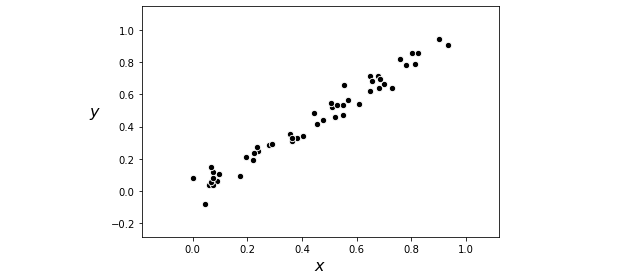

In [8]:
# load in dataset
data = np.loadtxt(data_path_1, delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# plot dataset
demo = section_5_2_helpers.linear_regression_visualizer(data)
demo.plot_data()

The contour plot and corresponding surface generated by the Least Squares cost function using this data are shown below.  

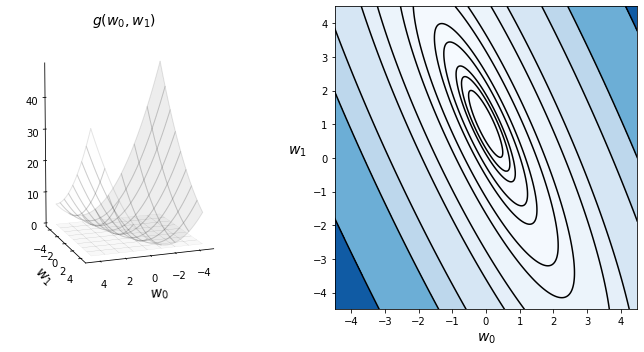

In [9]:
# show run in both three-dimensions and just the input space via the contour plot
section_5_2_helpers.static_visualizer().two_input_surface_contour_plot(least_squares,[],view = [10,70],xmin = -4.5, xmax = 4.5, ymin = -4.5, ymax = 4.5,num_contours = 30)

----

In the previous example we plotted the contour/surface for the Least Squares cost function for linear regression on a specific dataset. There we saw the elliptical contours and 'upward bending' shape of the surface indeed confirms the function's convexity in that case. However the Least Squares cost function for linear regression can mathematically shown to be  - in general - a convex function for *any dataset* (this is because one can show that it is always a convex quadratic - which is shown formally below). Because of this we can easily apply either gradient descent or Newton's method in order to minimize it. 

> The Least Squares cost function for linear regression is always convex regardless of the input dataset, hence we can easily apply first or second order methods to minimize it.

The generic practical considerations associated with each method still exist here i.e., with gradient descent we must choose a steplength / learning rate scheme, and Newton's method is practically limited to cases when $N$ is of moderate value (e.g., in the thousands). For the case of gradient descent we can use a fixed steplength value, a diminishing steplength scheme, or an adjustable method like backtracking line search.

While we will by default be using an automatic differentiator (`autograd` - as detailed in [Section 3.5](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_5_Automatic.html)) to perform both gradient descent and Newton's method on our machine learning cost functions, here one can (since this cost function is simple enough) 'hard code' the gradient by formally by writing it out 'by hand' (using the derivative rules detailed in the Appendix).  Doing so one can compute the gradient of the Least Squares cost in closed form as

\begin{equation}
\nabla g\left(\mathbf{w}\right) = \frac{2}{P}\sum_{p=1}^{P} \mathring{\mathbf{x}}_{p}^{\,}\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,} - \overset{\,}{y}_p^{\,}\right)
\end{equation}

Furthermore, the in performing Newton's method one can also compute the Hessian of the Least Squares cost by hand.  Moreover since the cost is a convex quadratic *only a single Newton step can completely minimize it*.  This single-Newton-step solution is often referred to as minimizing the Least Squares cost via its *normal equations*.  The system of equations solved in taking this single Newton step is equivalent to the *first order system* (see [Section 3.2](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_2_First.html)) for the Least Squares cost function

\begin{equation}
\left(\sum_{p=1}^{P} \mathring{\mathbf{x}}_p^{\,}\mathring{\mathbf{x}}_p^T \right) \mathbf{w}_{\,}^{\,} =  \sum_{p=1}^{P} \mathring{\mathbf{x}}_p^{\,} y_p^{\,}.
\end{equation}

#### <span style="color:#a50e3e;">Example 3: </span> Using gradient descent to minimize the Least Squares cost on our toy dataset

In the next Python cell minimize the Least Squares cost using the toy dataset presented in Example 2.  We use gradient descent and employ a fixed steplength value $\alpha = 0.5$ for all 75 steps until approximately reaching the minimum of the function.  Here we employ the file ``optimizers.py`` which contains a short list of optimization algorithms we constructed explicitly in Chapters 2-4, including gradient descent and Newton's method.

In [10]:
# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares; w = np.array([-1.0,-2.0])[:,np.newaxis]; max_its = 75; alpha_choice = 0.5;
weight_history,cost_history = section_5_2_helpers.gradient_descent(g,alpha_choice,max_its,w)

Now we animate the process of gradient descent run above.  The contour of the cost function is shown in the right panel with each step plotted on top, colored from green at the start of the run to red at its end (green and red points mark the initialization and final weights reached by gradient descent).  As you move the slider from left to right the gradient descent process animates, until completion when the slider is all the way to the right. Simultaneously, in the left panel the corresponding linear model given by the weights at each step of gradient descent is drawn. The linear model is colored to match the step of gradient descent, so near the beginning of the run the line is green whereas near the end it is plotted red.  

As can be seen while pushing the slider to the right, as the minimum of the cost function is neared, the corresponding weights provide a better and better fit to the data - with the best fit occurring at the end of the run (at the point closest to the minimum).

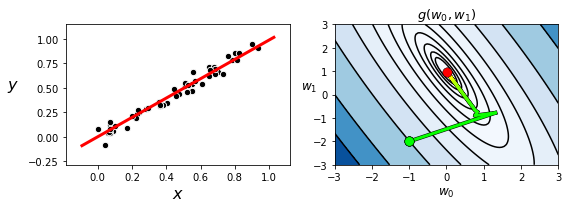

In [11]:
# animate descent process
demo.animate_it_2d(video_path_1,weight_history,num_contours = 30,fps=20)

In [12]:
# load video into notebook
from IPython.display import HTML
HTML("""
<video width="1000" height="400" controls loop>
  <source src='""" + video_path_1 + """' type="video/mp4">
  </video>
""")

Whenever we use a local optimization method like gradient descent we must properly tune the steplength parameter $\alpha$.  We did this for the run above by trying several fixed steplength values.  Below we re-create those runs using $\alpha = 0.5$, $\alpha = 0.01$, showing the the cost function history plot for each steplength value choice.  We can see from the plot that indeed the first steplength value works considerably better.

This illustrates why - in machine learning / deep learning contexts - the steplength parameter is often referred to as the *learning rate*, since this value does indeed determine how quickly the proper parameters of our linear regression model are learned.

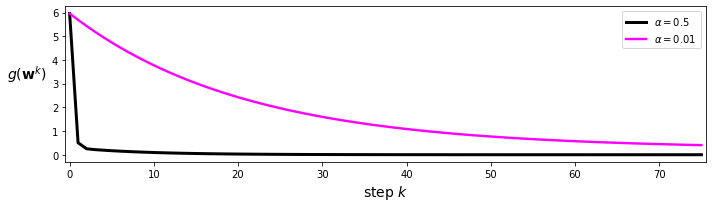

In [13]:
# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares; w = np.array([-1.0,-2.0])[:,np.newaxis]; max_its = 75; alpha_choice = 0.5;
weight_history_1,cost_history_1 = section_5_2_helpers.gradient_descent(g,alpha_choice,max_its,w)

# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares; w = np.array([-1.0,-2.0])[:,np.newaxis]; max_its = 75; alpha_choice = 10**(-2);
weight_history_2,cost_history_2 = section_5_2_helpers.gradient_descent(g,alpha_choice,max_its,w)

# plot the cost function history for a given run
section_5_2_helpers.static_visualizer().plot_cost_histories([cost_history_1,cost_history_2],start = 0,points = False,labels = [r'$\alpha = 0.5$',r'$\alpha = 0.01$'])

#### <span style="color:#a50e3e;">Example 4: </span> An example with input dimension $N=2$ 

In this example we look at another toy dataset with $N = 2$ inputs, which is plotted by the next Python cell.  This dataset consists of 50 data points taken randomly from the hyperplane $y = 1 - x_1 - x_2$ with the addition of a small amount of random Gaussian noise to their $y$ value.

/usr/src/mlr2/notes/5_Linear_regression/./chapter_5_library/section_5_2_helpers.py:379: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot(gs[1],projection='3d');


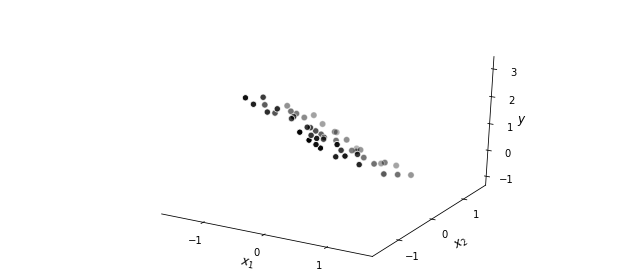

In [14]:
# load in dataset
data = np.loadtxt(data_path_2, delimiter = ',')


x = data[:-1,:]
y = data[-1:,:] 

# plot dataset
demo = section_5_2_helpers.linear_regression_visualizer(data)
demo.plot_data()

In the next Python cell we minimize the Least Squares cost using the gradient descent, a constant steplength value $\alpha = 10^{-1}$ for 100 iterations beginning at the point

$$\begin{bmatrix} w_0 \\ w_1 \\ w_2 \end{bmatrix} = \begin{bmatrix} 1 \\ 1 \\ 1 \end{bmatrix}$$  

In [15]:
# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares; w = np.array([1.0,1.0,1.0])[:,np.newaxis]; max_its = 100; alpha_choice = 10**(-1);
weight_history,cost_history = section_5_2_helpers.gradient_descent(g,alpha_choice,max_its,w)

Now we animate this descent run.  Since the linear model in this case has 3 parameters we cannot visualize each step on the contour / surface of the cost function itself, and thus must use a cost function plot (first introduced in our series on *mathematical optimization*) to keep visual track of the algorithm's progress.

In the left panel below we show the dataset, along with the hyperplane defined by $y = w_0 + x_1w_1 + x_2w_2$ whose weights are given at the current step in the gradient descent run.  In the right panel the corresponding cost function value which plots the evaluation of each step up to the current one.  Pushing the slider from left to right animates the run from start to finish - updating corresponding hyperplane in the left panel as well as cost function value in the right at each step (both of which simultaneously colored green at the start of the run, and gradually fade to red as the run ends).

As can be seen while pushing the slider to the right, as the minimum of the cost function is neared the corresponding weights provide a better and better fit to the data - with the best fit occurring at the end of the run (at the point closest to the minimum).

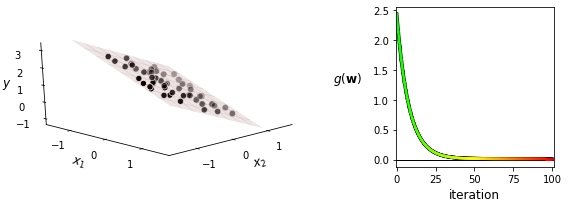

In [16]:
# animate descent process
demo.animate_it_3d(video_path_2,weight_history,view = [10,-40],viewmax = 1.3,fps=20)

In [17]:
# load video into notebook
from IPython.display import HTML
HTML("""
<video width="1000" height="400" controls loop>
  <source src='""" + video_path_2 + """' type="video/mp4">
  </video>
""")

---

#### <span style="color:#a50e3e;">Example 5: </span> Completely minimizing the Least Squares cost function using a single Newton step

In Example 6 of [Section 4.4](https://jermwatt.github.io/machine_learning_refined/notes/4_Second_order_methods/4_4_Newtons.html) we described how Newton's method perfectly minimizes any convex quadratic function in a single step since it is built on successively minimizing quadratic approximations to a given function.  As we show formally in the next Subsection, the Least Squares cost function is a convex quadratic *for any dataset*.  We show this by repeating the experiment in the previous example using a single Newton step.

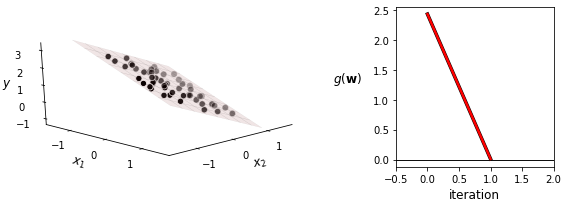

In [18]:
# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares; w = np.array([1.0,1.0,1.0])[:,np.newaxis]; max_its = 1; 
weight_history,cost_history = section_5_2_helpers.newtons_method(g,max_its,w)

# animate descent process
demo.animate_it_3d(video_path_3,weight_history,view = [10,-40],viewmax = 1.3,fps=0.25)

In [19]:
# load video into notebook
from IPython.display import HTML
HTML("""
<video width="1000" height="400" controls loop>
  <source src='""" + video_path_3 + """' type="video/mp4">
  </video>
""")

## Technical details: proof of Least Squares convexity and Lipschitz constants

### Proof that the Least Squares cost function is always convex

A little re-arrangement shows that the Least Squares cost function for linear regression is always a convex quadratic, and hence is a convex function.  Here we will briefly ignore the bias term $w_0$ for notational simplicity, but the same argument holds with it as well.

We can do this by first examining just the $p^{th}$ summand.  By expanding (performing the squaring oepration) we have

\begin{equation}
\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w} - \overset{\,}{y}_p^{\,}\right)^2 = \left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w} - \overset{\,}{y}_p^{\,}\right)\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w} - \overset{\,}{y}_p^{\,}\right) = \overset{\,}{y}_p^2 - 2\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}\overset{\,}{y}_p + \mathring{\mathbf{x}}_{p}^{T}\mathbf{w}\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}  
\end{equation}

where we have arranged the terms in increasing order of degree.

Now - since the inner product $\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}   = \overset{\,}{\mathbf{w}}^T\mathring{\mathbf{x}}_{p}$ we can switch around the second inner product in the first term on the right, giving equivalently

\begin{equation}
=\overset{\,}{y}_p^2 - 2\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}\overset{\,}{y}_p + \overset{\,}{\mathbf{w}}^T\mathring{\mathbf{x}}_{p}^{\,}\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}
\end{equation}

This is only the $p^{th}$ summand.  Summing over all the points gives analagously

\begin{equation}
\,g\left(\mathbf{w}\right)= \frac{1}{P}\sum_{p=1}^{P}\left(\overset{\,}{y}_p^2 - 2\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}\overset{\,}{y}_p + \overset{\,}{\mathbf{w}}^T\mathring{\mathbf{x}}_{p}^{\,}\mathring{\mathbf{x}}_{p}^{T}\mathbf{w} \right) = \frac{1}{P}\sum_{p=1}^{P}\overset{\,}{y}_p^2 - \frac{2}{P}\sum_{p=1}^{P}\overset{\,}{y}_p^{\,}\mathring{\mathbf{x}}_{p}^{T}\mathbf{w} + \frac{1}{P}\sum_{p=1}^{P}\overset{\,}{\mathbf{w}}^T\mathring{\mathbf{x}}_{p}^{\,}\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}
\end{equation}

And from here we can spot that indeed the Least Squares cost function is a quadratic, since denoting

\begin{array}
\
a = \frac{1}{P}\sum_{p=1}^{P}\overset{\,}{y}_p^2  \\
\mathbf{b} = -\frac{2}{P}\sum_{p=1}^{P}\mathring{\mathbf{x}}_{p}^{\,}\overset{\,}{y}_p^{\,} \\
\mathbf{C} = \frac{1}{P}\sum_{p=1}^{P}\mathring{\mathbf{x}}_{p}^{\,} \mathring{\mathbf{x}}_{p}^T   
\end{array}


we can write the Least Squares cost equivalently as 

\begin{equation}
g\left(\mathbf{w}\right) = a^{\,} + \mathbf{b}^T\mathbf{w}^{\,} + \mathbf{w}^T\mathbf{C}^{\,}\mathbf{w}^{\,}
\end{equation}

which is of course a general quadratic.  But furthermore because the matrix $\mathbf{C}$ is constructed from a sum of *outer product* matrices it is also convex, since the eigenvalues of such a matrix are always nonnegative.

### Computation of the Lipschitz constant 

Since we have just seen that the cost function is convex in order to compute a Lipschitz constant we can simply compute the largest eigenvalue of the matrix $\mathbf{C} = \frac{1}{P}\sum_{p=1}^{P}\mathring{\mathbf{x}}_{p}^{\,} \mathring{\mathbf{x}}_{p}^T   $.  This is precisely given as the *2-norm* of this matrix, squared

\begin{equation}
L = \left\Vert \mathbf{C} \right\Vert_2^2
\end{equation}

which one can compute via e.g., the *power method*.

For a larger but easier to compute Lipschitz constant one can use the trace of the matrix $\mathbf{C}$, since this equals the sum of all eigenvalues, which in this case must be larger than its maximum value since all eigenvalues are non-negative.